# Reinforcement Learning

Reinforcement Learning (RL) algorithms help the computer to make a sequence of decissions. The algorithm learns to achieve in an uncertain, potentially complex environment.

Here an agent makes decisions by following a policy based on which actions to take, and it learns from the consequences of these actions through rewards or penalties

Common types of Reinforcement Learning tasks includes the following:

Markov Decission Process for how the state of a system evolves as different actions are applied to the system. A few different quantities come together to form an MDP

Q-learning: This is a model-free reinforcement learning algorithm that learns the value of an action in a particular state.

Deep Q-Networks (DQN): It combines Q-learning with deep neural networks, allowing the approach to learn successful policies directly from high-dimensional sensory inputs.

Policy Gradient Methods: These methods optimize the parameters of a policy directly as opposed to estimating the value of actions.

Monte Carlo Tree Search (MCTS): Used in decision processes for finding optimal decisions by playing out scenarios, notably used in games like Go.

## Real-world examples of Reinforcement Learning

- Games
- Robotics
- Industrial Controllers

## Creating a environment

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn

2024-10-30 15:31:06.082057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

## Building an Agent

In [7]:
# %pip install gym
# %pip install pyglet==1.2.4
# %pip install pygame

zsh:1: no matches found: gym[all]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gym

Get available environments

In [ ]:
gym.envs.registry

In [11]:
# env = gym.make("CartPole-v1", render_mode="rgb_array")
# observation, info = env.reset(seed=42)

# for _ in range(1000):
#     action = env.action_space.sample()
#     observation, reward, terminated, truncated, info = env.step(action)

#     if terminated or truncated:
#         observation, info = env.reset()
# env.close()

In [4]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [5]:
img = env.render()
img.shape

(400, 600, 3)

In [6]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

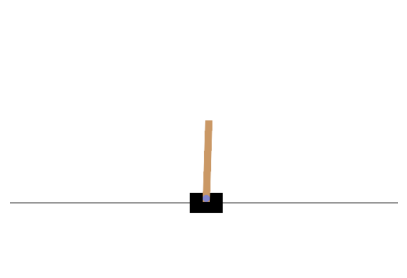

In [7]:
plot_environment(env)
plt.show()

Get the possible actions in this environment

In [8]:
env.action_space

Discrete(2)

In [15]:
action = 1
obs, reward, done, stopped, info = env.step(action)
print(obs)
print(reward)
print(done)
print(info)

[-0.04258951  0.04680781  0.03327436  0.04526351]
1.0
False
{}


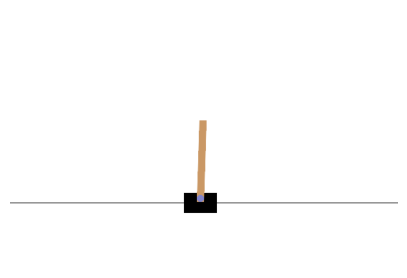

In [16]:
plot_environment(env)
plt.show()

An example with harc-coded policy

In [ ]:
# env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, stopped, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

Policy Gradients

In [18]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [19]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [20]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [21]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [22]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [23]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [24]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

2024-10-30 15:34:41.338411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 15:34:41.338482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
obs, info = env.reset(seed=42)

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

In [28]:
frames = render_policy_net(model)
plot_animation(frames)

NameError: name 'render_policy_net' is not defined

## Markov Chains

In [29]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


## Markov Decision Process

In [30]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

: 